# WSI - laboratorium 6

Zadanie: Uczenie (się) ze wzmocnieniem

Autor: Jakub Mazurkiewicz (300226)

## Klasy pomocnicze

### Zestaw hiperparametrów

Poniższa klasa reprezentuje zestaw hiperparametrów:

In [1]:
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    learning_rate: float = 0.5
    discount_factor: float = 0.6
    epsilon: float = 0.1
    episodes: int = 10000

    def __repr__(self):
        return '\n'.join([
            f'Współczynnik uczenia: {self.learning_rate}',
            f'Dyskonto: {self.discount_factor}',
            f'Epsilon: {self.epsilon}',
            f'Ilość epizodów: {self.episodes}'
        ])

### Statystyki z pojedynczego epizodu

Poniższa klasa reprezentuje statystyki z pojedynczego epizodu:

In [2]:
@dataclass
class EpisodeStats:
    penalty_count: int = 0
    total_reward: int = 0

### Wyniki ewaluacji

Poniższa klasa reprezentuje wyniki ewaluacji:

In [3]:
from typing import List

@dataclass
class EvaluationResult:
    avg_epoch_count: float
    avg_penalty: float
    learning_episodes: int
    stats: List[EpisodeStats]

    def __repr__(self):
        return '\n'.join([
            f'Po {self.learning_episodes} epizodach:',
            f'* Średnia ilość epok na epizod: {self.avg_epoch_count}',
            f'* Średnia ilość kar na epizod: {self.avg_penalty}'
        ])

## Klasa implementująca algorytmu Q-learning

### Schemat nagradzania

Schemat nagradzania jest taki sam jak w bibliotece `gym`:

* -1 za każdy krok (w kodzie: `epoch`), który nie kończy się wyższą nagrodą,
* +20 za pomyślny przejaz z pasażerem,
* -10 za wykonanie operacji "pickup" lub "dropoff" w niedozwolonymi miejscu.


### Kod

Poniższa klasa implementuje algorytm Q-learning:

In [4]:
import random
from typing import Tuple
import numpy as np
from gym import Env

class QLearning:
    def __init__(self, environment: Env, hyperparameters: Hyperparameters):
        self.env = environment
        self.params = hyperparameters
        self.qtable = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.total_learning_episodes = 0

    def learn(self, seed=None) -> Tuple[List[EpisodeStats], List[EvaluationResult]]:
        learning_stats = []
        evaluation_stats = []
        stop_point_for_evaluation = self.params.episodes // 4

        for episode in range(self.params.episodes):
            state = self.env.reset() if seed is None else self.env.reset(seed=random.getrandbits(64))
            stats = EpisodeStats()
            done = False

            while not done:
                action = self._epsilon_greedy_exploration(state)
                next_state, reward, done, _ = self.env.step(action)
                self.qtable[state, action] = self.qtable[state, action] + self.params.learning_rate * (
                    reward + self.params.discount_factor * np.max(self.qtable[next_state]) - self.qtable[state, action])
                state = next_state
                stats.total_reward += reward
                stats.penalty_count += 1 if reward < 0 else 0
            learning_stats += [stats]

            if (episode + 1) % stop_point_for_evaluation == 0:
                evaluation_stats += [self.evaluate()]
            self.total_learning_episodes += 1
        return learning_stats, evaluation_stats

    def _epsilon_greedy_exploration(self, state):
        if np.random.random() < self.params.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.qtable[state])

    def evaluate(self, seed=None) -> EvaluationResult:
        total_epochs = 0
        total_penalties = 0
        stat_list = []

        for _ in range(self.params.episodes):
            state = self.env.reset() if seed is None else self.env.reset(seed=random.getrandbits(64))
            stats = EpisodeStats()
            epochs = 0
            reward = 0
            done = False

            while not done:
                action = np.argmax(self.qtable[state])
                state, reward, done, _ = self.env.step(action)
                epochs += 1
                total_penalties += 1 if reward < 0 else 0
                stats.total_reward += reward
                stats.penalty_count += 1 if reward < 0 else 0

            total_epochs += epochs
            stat_list += [stats]

        return EvaluationResult(
            avg_epoch_count=(total_epochs / self.params.episodes),
            avg_penalty=(total_penalties / self.params.episodes),
            learning_episodes=self.total_learning_episodes,
            stats=stat_list
        )

    def save_qtable(self, filename):
        np.savetxt(filename, self.qtable)

c:\Users\mazku\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


### Dodatkowe informacje

* W trakcie uczenia 4 razy jest dokonywana ewaluacja,
* Wykorzystywana jest strategia ϵ-zachłanna (funkcja `QLearning._epsilon_greedy_exploration`).

## Eksperymenty

### Funkcja do tworzenia wykresów

In [5]:
import matplotlib.pyplot as plt

def make_stats_plot(stats: List[EpisodeStats], major_title: str):
    episodes = len(stats)
    fig, axes= plt.subplots(1, 2, dpi=100)
    fig.suptitle(major_title)
    axes[0].scatter(range(1, episodes + 1), [stat.penalty_count for stat in stats], s=3)
    axes[0].set_xlabel('Numer epizodu')
    axes[0].set_ylabel('Ilość kar')
    axes[0].set_title('Ilość kar na epizod')
    axes[0].grid(True)
    axes[1].scatter(range(1, episodes + 1), [stat.total_reward for stat in stats], s=3)
    axes[1].set_xlabel('Numer epizodu')
    axes[1].yaxis.set_label_position('right')
    axes[1].yaxis.tick_right()
    axes[1].set_ylabel('Suma nagród')
    axes[1].set_title('Suma nagród na epizod')
    axes[1].grid(True)

### Funkcja wspomagająca przeprowadzanie eksperymentów

In [6]:
import gym
import numpy as np
import pandas as pd

def experiment(learning_rate: float, discount_factor: float, epsilon: float, episodes: int):
    env = gym.make("Taxi-v3")
    algo = QLearning(env, Hyperparameters(learning_rate, discount_factor, epsilon, episodes))
    learning_stats, evaluation_stats = algo.learn()
    make_stats_plot(learning_stats, 'Proces uczenia')
    for stat in evaluation_stats:
        episode = stat.learning_episodes + 1
        make_stats_plot(stat.stats, f'Ewaluacja w trakcie nauki (po {episode} epizodzie nauki)')

    episodes = [f'Po {stats.learning_episodes + 1} epizodach' for stats in evaluation_stats]
    avg_epoch_count = [stats.avg_epoch_count for stats in evaluation_stats]
    avg_penalty = [stats.avg_penalty for stats in evaluation_stats]
    summary = np.transpose([episodes, avg_epoch_count, avg_penalty])
    print(pd.DataFrame(summary, columns=['Epizod', 'Średnia ilość epok na epizod', 'Średnia ilość kar na epizod']))
    plt.show()

### Metoda przeprowadzania eksperymentów

* Każdy eksperyment polega na zmianie jednego z hiperparametrów, tak aby uzyskać lepszy wynik niż wcześniej,
* W trakcie eksperymentu tworzona jest tabla przedstawiająca wyniki ewaluacji po `n` epizodach. Tabela posiada dokładnie 4 rzędy zawierające:
  - Średnią ilość epok na epizod ("epoka" to pojedyncza akcja taksówki wykonana przez algorytm), czyli ilość ruchów potrzebnych do rozwiązania problemu,
  - Średnią ilość kar na epizod ("kara" to sytuacja, w której nagroda jest mniejsza od zera).
* W każdym eksperymencie jest tworzonych 5 wykresów:
  - Pierwszy przedstawia ilość kar i sumę nagród w zależności od epizodu w trakcie uczenia,
  - Kolejne cztery wykresy demonstrują wynik ewaluacji wykonanej w trakcie przerwy w nauczaniu.

### Eksperyment 1 - wstępnie dobrane hiperparametry

Wstępnie dobrane hiperparametry:

* `learning_rate` (beta): 0.5
* `discount_factor` (gamma): 0.6
* `epsilon`: 0.1
* `episodes`: 10000 (parametr ten oznacza ilość epizodów wykorzystywanych przy nauczaniu i ewaluacji)

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                      19.7946                     18.8312
1   Po 5000 epizodach                      13.5385                     12.5411
2   Po 7500 epizodach                      13.0777                     12.0777
3  Po 10000 epizodach                      13.0472                     12.0472


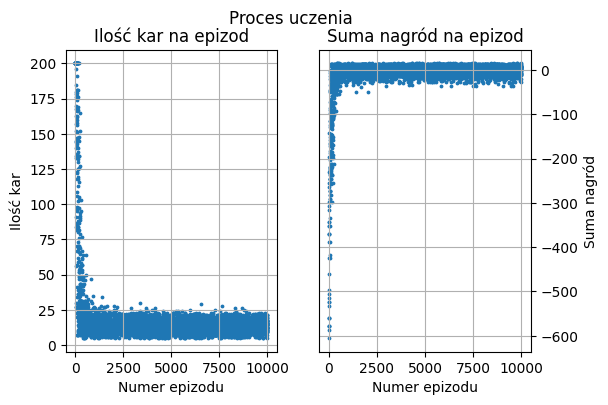

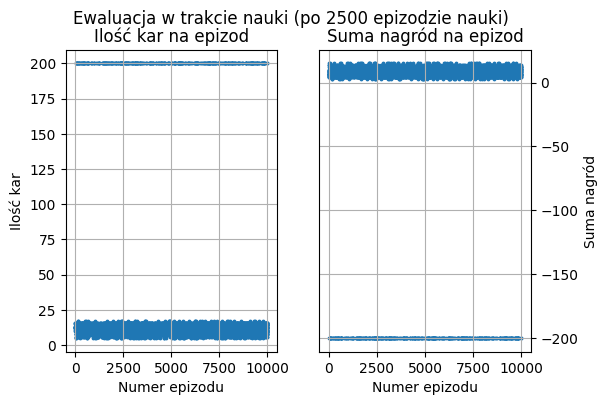

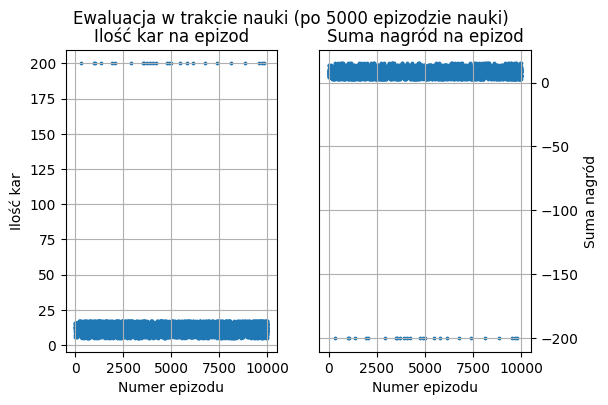

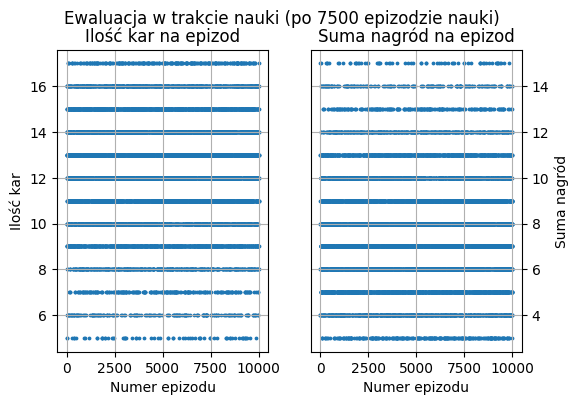

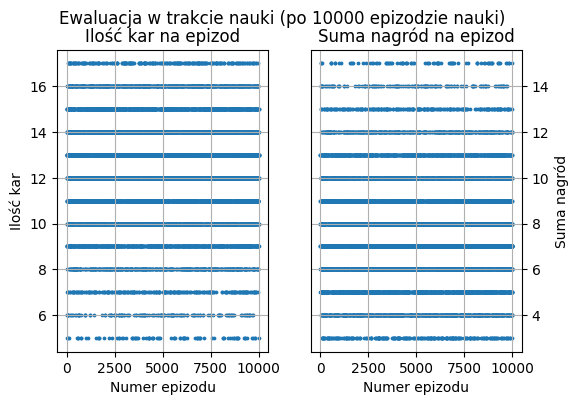

In [7]:
experiment(learning_rate=0.5, discount_factor=0.6, epsilon=0.1, episodes=10000)

Jak widać na pierwszym wykresie ilość kar spadała bardzo szybko do około 25 już po 1000 epizodach.

Na wykresie przedstawiającym ewaluację po 5000 epizodach nauki widać, że przypadki w których ilość kar wynosi 200 są nieliczne. Po 7500 epizodach nauki ewaluacja pokazała, że nie występują przypadki w których ilość kar jest większa od 17 (przedostatni wykres).

### Eksperyment 2 - zwiększenie parametru `learning_rate`

W tym eksperymencie parametr `learning_rate` został zwiększony z 0.5 do 3.0

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                        200.0                       200.0
1   Po 5000 epizodach                        200.0                       200.0
2   Po 7500 epizodach                        200.0                       200.0
3  Po 10000 epizodach                        200.0                       200.0


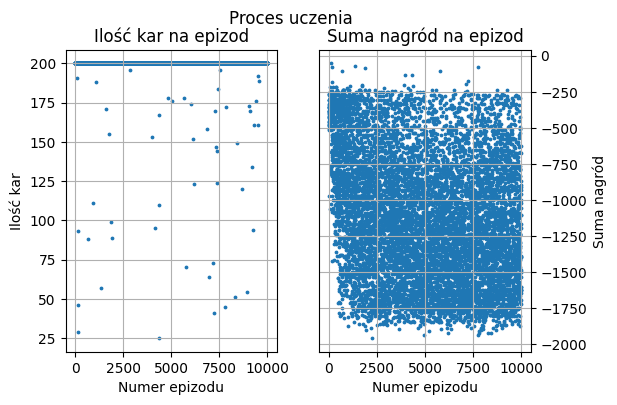

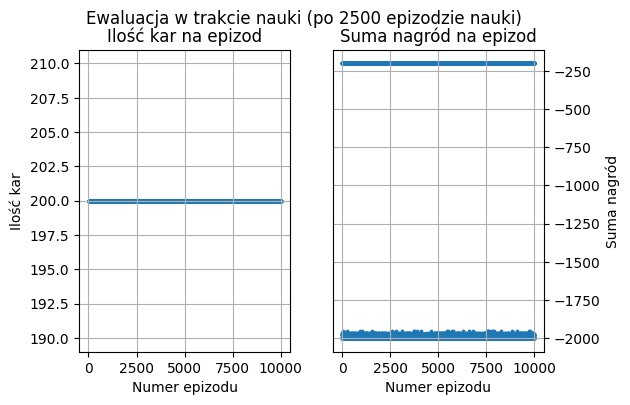

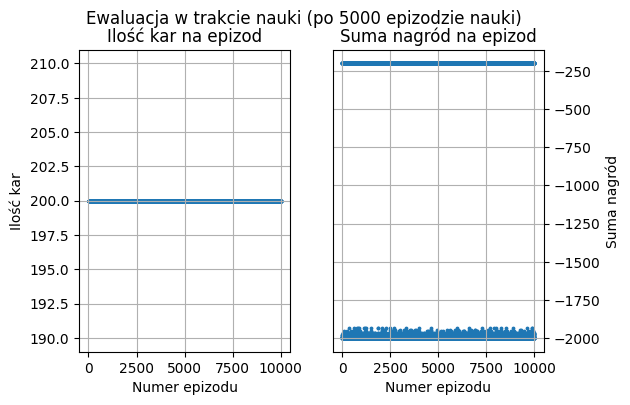

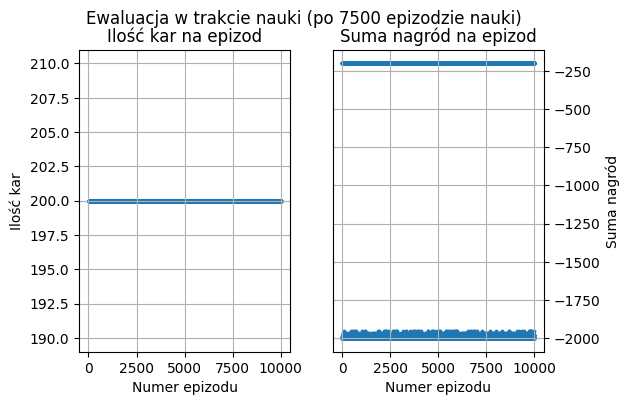

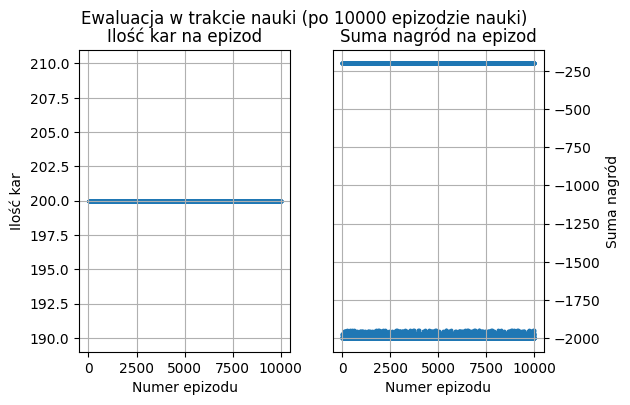

In [8]:
experiment(learning_rate=3.0, discount_factor=0.6, epsilon=0.1, episodes=10000)

Wniosek: zwiększenie wartości `learning_rate` do 3.0 wpłynęło bardzo negatywnie na wyniki:
 
* Proces uczenia znacznie się wydłużył (o kilka minut),
* Model niczego się nie nauczył - średnia ilość kar na epizod wynosiła 200 w każdej ewaluacji. Pokazują to także wykresy ewaluacji - ilość kar na epizod w praktycznie wszystkich przypadkach wynosi około 200.

### Eksperyment 3 - zmniejszenie parametru `learning_rate`

W tym eksperymencie hiperparametr `learning_rate` został zmniejszony z 0.5 do 0.1.

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                     111.1198                    110.6488
1   Po 5000 epizodach                      66.6058                     65.8952
2   Po 7500 epizodach                      45.0016                     44.1746
3  Po 10000 epizodach                      32.9258                     32.0335


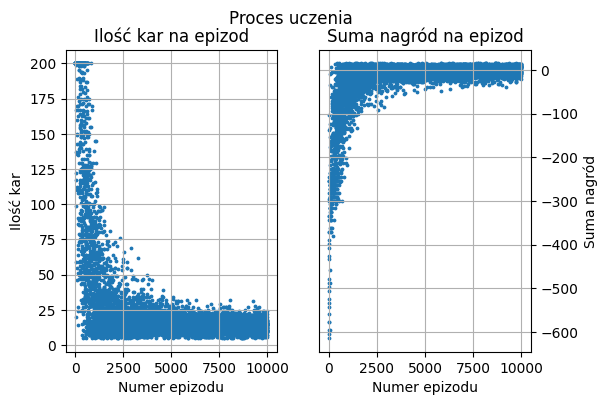

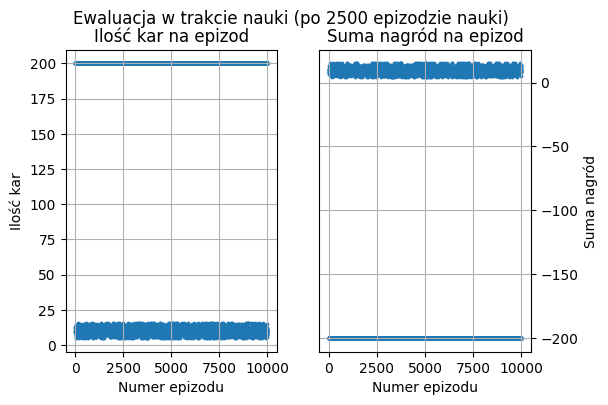

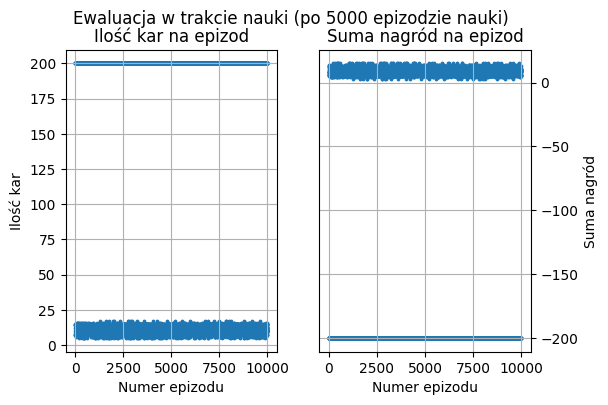

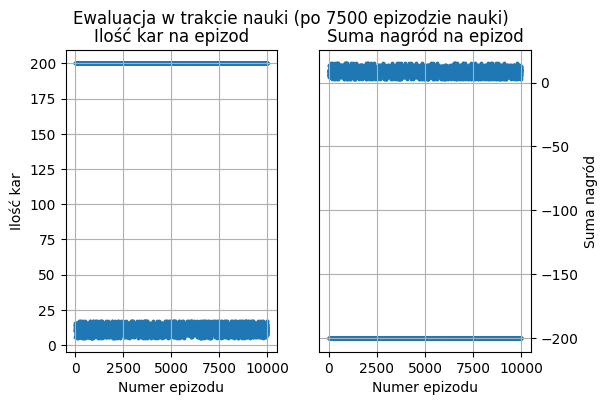

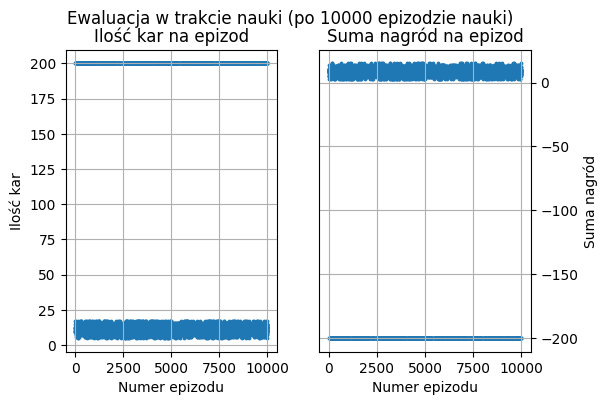

In [9]:
experiment(learning_rate=0.1, discount_factor=0.6, epsilon=0.1, episodes=10000)

Wniosek: zmniejszenie hiperparametru `learning_rate` wpłynęło negatywnie (w małym stopniu) na uzyskane wyniki - przykładowo, po 10000 epizodach średnia ilość kar na epizod była większa niż dla `learning_rate=0.5`. Wynika to z tego, że ciągle pojawiały się przypadki w których ilość kar wynosiła 200.

Dodatkowo porównując wykres przedstawiający ilość kar na epizod w trakcie nauki dla `learning_rate=0.5` oraz `learning_rate=0.1` można zauważyć, że proces nauki przebiegł wolniej. 

### Eksperyment 4 - zwiększenie hiperparametru `discount_factor`

W tym eksperymencie hiperparametr `discount_factor` został zwiększony z 0.6 do 0.9.

Wartość hiperparametru `learning_rate` została przywrócona do 0.5.

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                       13.084                      12.084
1   Po 5000 epizodach                      13.1087                     12.1087
2   Po 7500 epizodach                      13.0945                     12.0945
3  Po 10000 epizodach                      13.0229                     12.0229


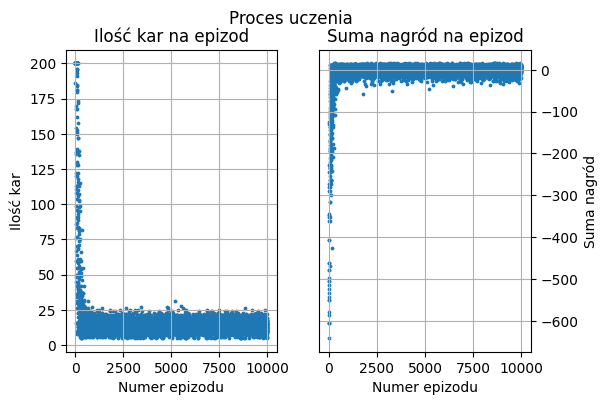

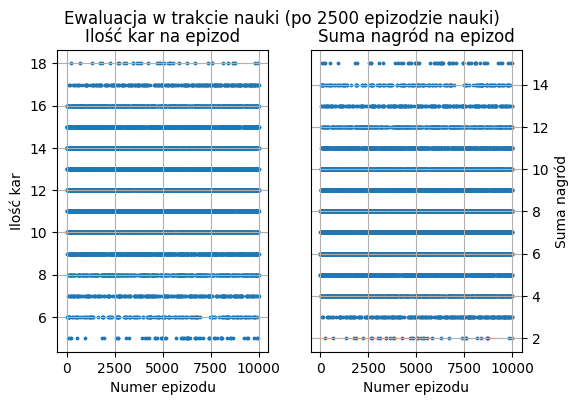

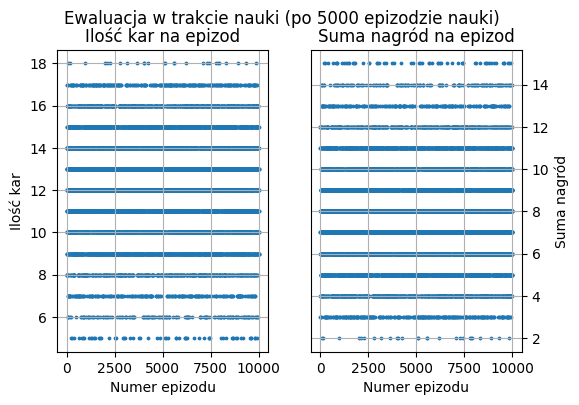

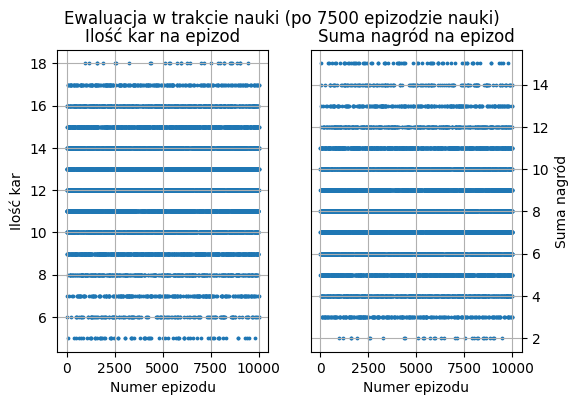

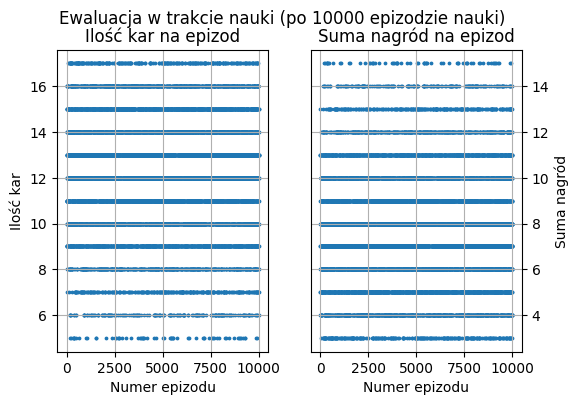

In [10]:
experiment(learning_rate=0.5, discount_factor=0.9, epsilon=0.1, episodes=10000)

Zwiększenie parametru `discount_factor` wpłynęło bardzo pozytywanie na tempo nauczania. Ewaluacja po 2500 epizodach nauki pokazała, że nie występują przypadki w których ilość kar przekracza 17.

### Eksperyment 5 - zmniejszenie parametru `discount_factor`

W tym eksperymencie hiperparametr `discount_factor` został zmniejszony z 0.6 do 0.1.

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                      44.1564                     43.3245
1   Po 5000 epizodach                      18.1087                     17.1356
2   Po 7500 epizodach                       13.753                     12.7565
3  Po 10000 epizodach                      13.0967                     12.0967


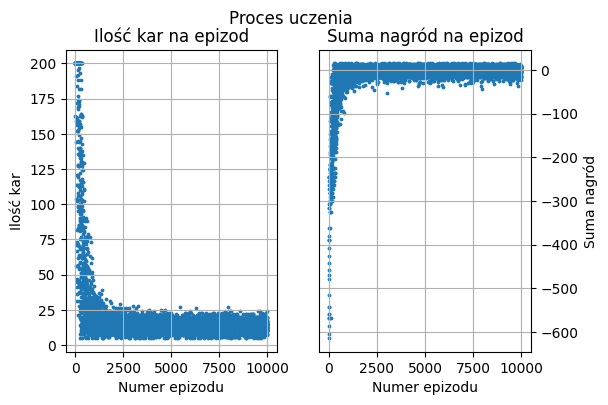

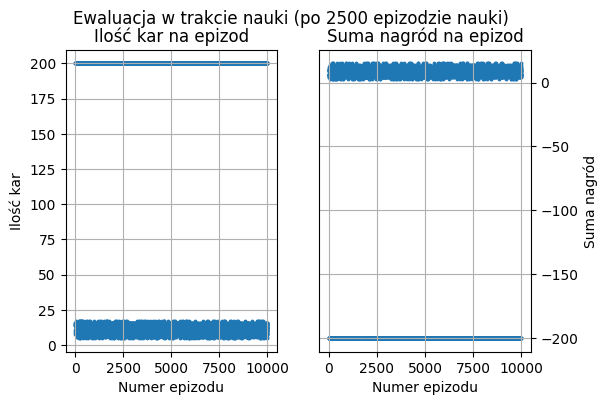

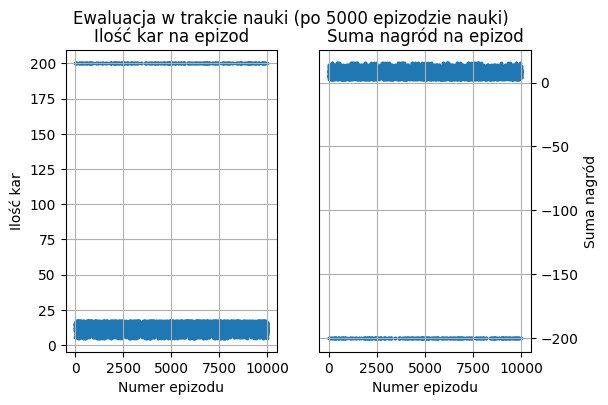

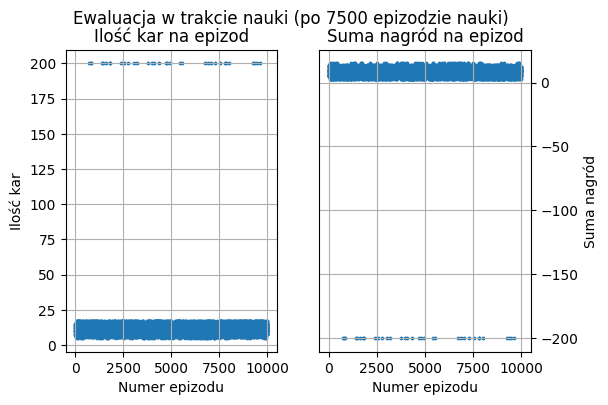

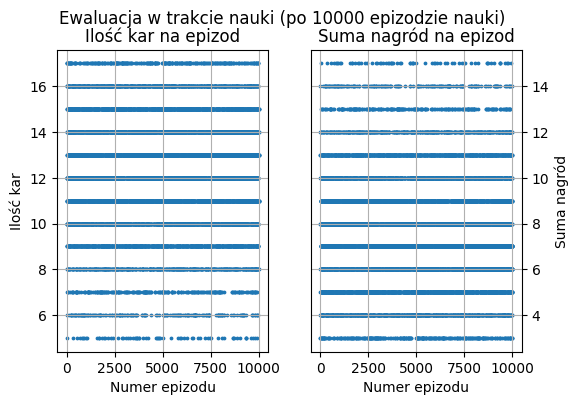

In [11]:
experiment(learning_rate=0.5, discount_factor=0.1, epsilon=0.1, episodes=10000)

Wniosek: zmniejszenie hiperparametru `discount_factor` wpłynęło negatywnie na tempo uczenia się.

### Eksperyment 6 - zwiększenie hiperparametru `epsilon`

W tym eksperymencie hiperparametr `epsilon` został zwiększony z 0.1 do 0.9.

Parametr `discount_factor` został zmieniony na 0.9 (tak jak w eksperymencie nr 4).

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                      13.0762                     12.0762
1   Po 5000 epizodach                      13.0724                     12.0724
2   Po 7500 epizodach                      13.0806                     12.0806
3  Po 10000 epizodach                      13.0806                     12.0806


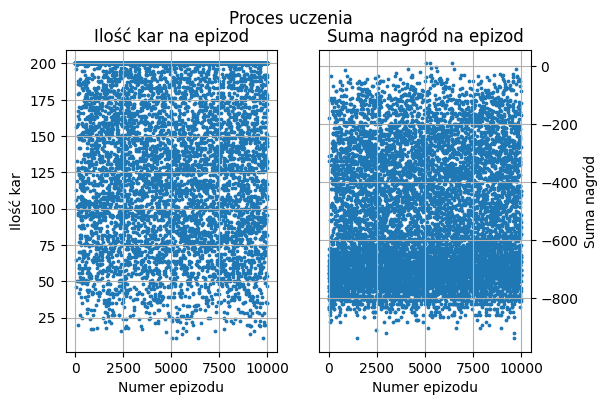

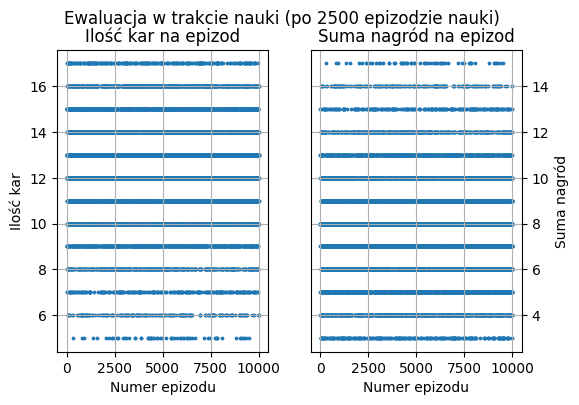

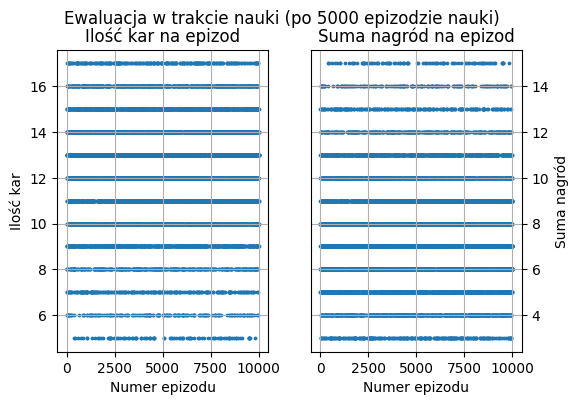

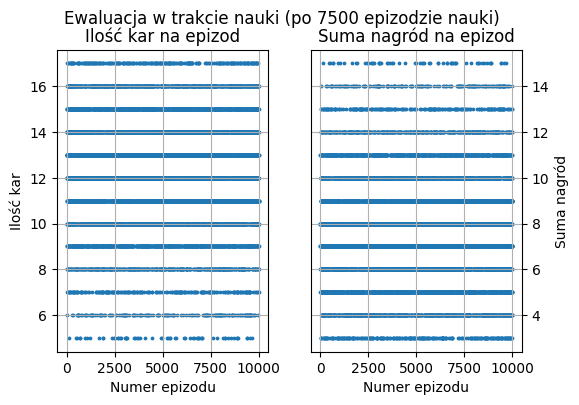

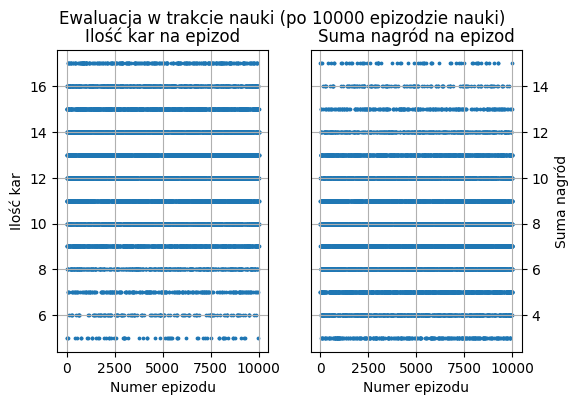

In [12]:
experiment(learning_rate=0.5, discount_factor=0.9, epsilon=0.9, episodes=10000)

Wnioski:

* Pierwszy wykres pokazuje, że zwiększenie parametru `epsilon` sprawiło, że algorytm podejmuje bardziej losowe decyzje. Nawet w późnych epizodach ilość kar dochodzi do 200,
* Kolejne wykresy pokazują, że proces nauczania przebiegł prawidłowo - mimo dużej losowości podejmowanych akcji w trakcie nauki algorytm prawidłowo nauczył się najbardziej korzystnych ruchów,
* Zwiększenie parametru epsilon wpłynęło także pozytywnie na tempo uczenia - już po 2500 epizodach nauki ewaluacja wykazała, że ilość kar nie przekraczała 17.

### Eksperyment 7 - zmniejszenie parametru `epsilon`

W tym eksperymencie hiperparametr `epsilon` został zmniejszony z 0.1 do 0.01.

               Epizod Średnia ilość epok na epizod Średnia ilość kar na epizod
0   Po 2500 epizodach                      13.1146                     12.1146
1   Po 5000 epizodach                      13.1143                     12.1143
2   Po 7500 epizodach                      13.1699                     12.1699
3  Po 10000 epizodach                      13.1488                     12.1488


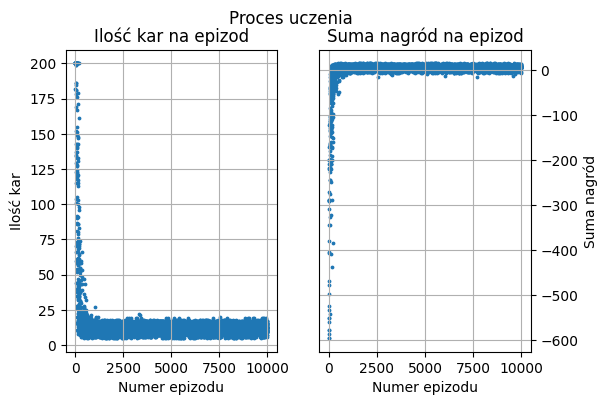

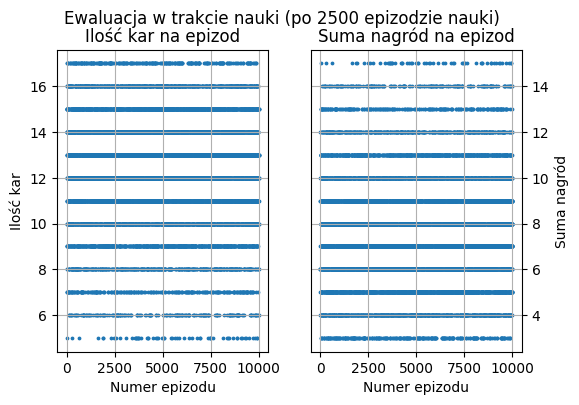

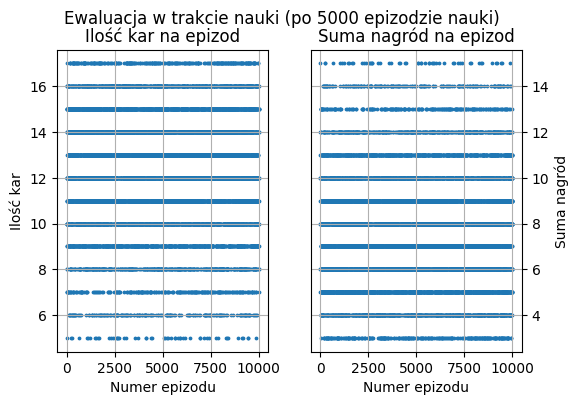

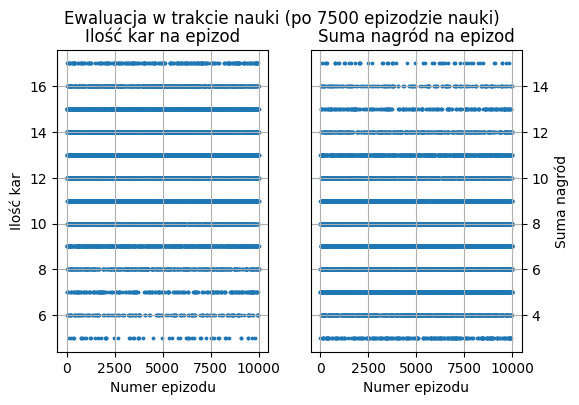

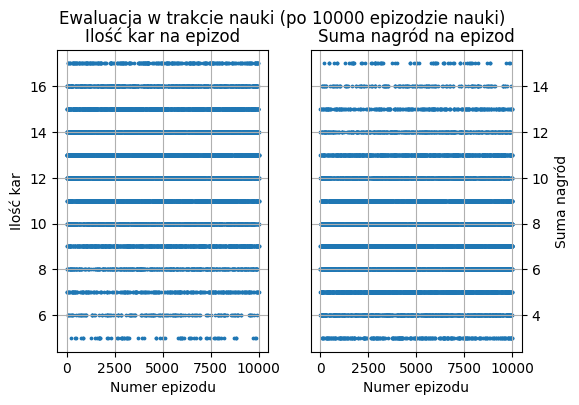

In [13]:
experiment(learning_rate=0.5, discount_factor=0.9, epsilon=0.01, episodes=10000)

Wniosek: zmniejszenie hiperparametru `epsilon` wpłynęło pozytywnie na tempo uczenia.

## Podsumowanie

* Hiperparametrem mającym największy wpływ na jakość modelu jest `learning_rate`. Zbyt duża jego wartość prowadziła do braku jakiegokolwiek uczenia, natomiast zbyt mała źle wpływała na jego tempo,
* Hiperparametr `discount_factor` ma istotny wpływ na tempo uczenia - jego duża wartość może znacząco przyspieszyć cały proces,
* Hiperparametr `epsilon` ma kluczowy wpływ na proces uczenia - zbyt duża jego wartość powoduje częstsze podejmowanie losowych decyzji nawet w późnych epizodach.

## Załączone programy

* `learn.py` - program przeprowadzający nauczanie oraz tworzący wykresy (wywołanie z flagą `-h` wyświetli listę flag pozwalających na dostosowanie hiperparametrów),
* `play.py` - program pokazujący efekt wykonanego wcześniej nauczania.